# Importing Dependencies

In [1]:
!pip install pyLDAvis[gensim] --user

In [2]:
import pandas as pd
import numpy as np
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim
from IPython.display import display
import multiprocessing
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from gensim import corpora

/opt/conda/lib/python3.10/site-packages/nltk/decorators.py:69: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  signature = inspect.formatargspec(regargs, varargs, varkwargs, defaults,


In [3]:
# Download necessary NLTK datasets
import nltk
nltk.data.path.append('/usr/share/nltk_data')

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Importing Dataset

In [4]:
df = pd.read_csv('/kaggle/input/amazon-product-reviews-dataset/7817_1.csv')

In [5]:
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1597 non-null   object 
 1   asins                 1597 non-null   object 
 2   brand                 1597 non-null   object 
 3   categories            1597 non-null   object 
 4   colors                774 non-null    object 
 5   dateAdded             1597 non-null   object 
 6   dateUpdated           1597 non-null   object 
 7   dimension             565 non-null    object 
 8   ean                   898 non-null    float64
 9   keys                  1597 non-null   object 
 10  manufacturer          965 non-null    object 
 11  manufacturerNumber    902 non-null    object 
 12  name                  1597 non-null   object 
 13  prices                1597 non-null   object 
 14  reviews.date          1217 non-null   object 
 15  reviews.doRecommend  

# Data Preprocessing

In [7]:
# Drop unnecessary columns and rows with missing values
df = df.drop(['id', 'asins', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'keys',
              'name', 'prices', 'reviews.date', 'reviews.doRecommend', 'reviews.numHelpful',
              'reviews.rating', 'reviews.sourceURLs', 'reviews.username'], axis=1)
df = df.dropna(subset=['reviews.text', 'reviews.title'])

# Drop duplicate rows
df = df.drop_duplicates(subset=['reviews.text', 'reviews.title'])

df = df.reset_index(drop=True)

In [8]:
import spacy
from nltk.corpus import stopwords
import string

# define stop words and punctuation
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    doc = nlp(punc_free)
    normalized = " ".join(token.lemma_ for token in doc)
    return normalized

doc_clean = [clean(str(txt) + ' ' + str(title)).split() for txt, title in zip(df['reviews.text'], df['reviews.title'])]

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Create the corpus and dictionary


In [9]:
# Create the corpus and dictionary
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Train the LDA model and print out the topics


In [10]:
# Train the LDA model and print out the topics
ldamodel = LdaModel(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

print(ldamodel.print_topics(num_topics=5, num_words=5))

[(0, '0.024*"fire" + 0.017*"amazon" + 0.016*"prime" + 0.011*"hdx" + 0.010*"tv"'), (1, '0.015*"headphone" + 0.015*"like" + 0.014*"I" + 0.014*"would" + 0.012*"kindle"'), (2, '0.026*"I" + 0.024*"headphone" + 0.016*"review" + 0.015*"people" + 0.015*"like"'), (3, '0.045*"kindle" + 0.016*"fire" + 0.016*"year" + 0.014*"tablet" + 0.013*"use"'), (4, '0.018*"great" + 0.014*"use" + 0.012*"amazon" + 0.010*"speaker" + 0.009*"echo"')]


# Display the visualization Topic Modelling

In [11]:
!pip install pyLDAvis

In [12]:
import pyLDAvis.gensim as gensimvis

def prepare(ldamodel, doc_term_matrix, dictionary):
    vis = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary)
    return vis

if __name__ == "__main__":
    # Create a process pool with 4 workers
    pool = multiprocessing.Pool(4)

    # Submit the `prepare()` function to the process pool
    vis = pool.apply_async(prepare, args=(ldamodel, doc_term_matrix, dictionary))

    # Get the result from the process pool
    vis = vis.get()

    # Display the visualization using IPython.display
    display(pyLDAvis.display(vis))

/opt/conda/lib/python3.10/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/opt/conda/lib/python3.10/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,


In [13]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    topic_num_list = []
    prop_topic_list = []
    topic_keywords_list = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_num_list.append(int(topic_num))
                prop_topic_list.append(round(prop_topic,4))
                topic_keywords_list.append(topic_keywords)
                break

    # Create DataFrame
    sent_topics_df = pd.DataFrame({'Dominant_Topic': topic_num_list,
                                   'Perc_Contribution': prop_topic_list,
                                   'Topic_Keywords': topic_keywords_list})

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename('Texts')], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=doc_clean)


# Top ten Dominant Topic

In [14]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.6617,"kindle, fire, year, tablet, use, read, book, h...","[initially, trouble, decide, paperwhite, voyag..."
1,1,3,0.7309,"kindle, fire, year, tablet, use, read, book, h...","[allow, preface, little, history, be, casual, ..."
2,2,3,0.7181,"kindle, fire, year, tablet, use, read, book, h...","[enjoy, far, great, read, original, fire, sinc..."
3,3,3,0.4945,"kindle, fire, year, tablet, use, read, book, h...","[buy, one, first, paperwhite, please, constant..."
4,4,3,0.5981,"kindle, fire, year, tablet, use, read, book, h...","[say, upfront, like, coroporate, hermetically,..."
5,5,1,0.3979,"headphone, like, I, would, kindle, work, nice,...","[previous, kindle, dx, second, kindle, year, l..."
6,6,3,0.7312,"kindle, fire, year, tablet, use, read, book, h...","[allow, preface, little, history, be, casual, ..."
7,7,1,0.4713,"headphone, like, I, would, kindle, work, nice,...","[get, mine, right, now, look, previous, genera..."
8,8,3,0.6610,"kindle, fire, year, tablet, use, read, book, h...","[initially, trouble, decide, paperwhite, voyag..."
9,9,3,0.8432,"kindle, fire, year, tablet, use, read, book, h...","[enjoy, far, great, read, original, fire, sinc..."


# Distribution of Dominant Topic

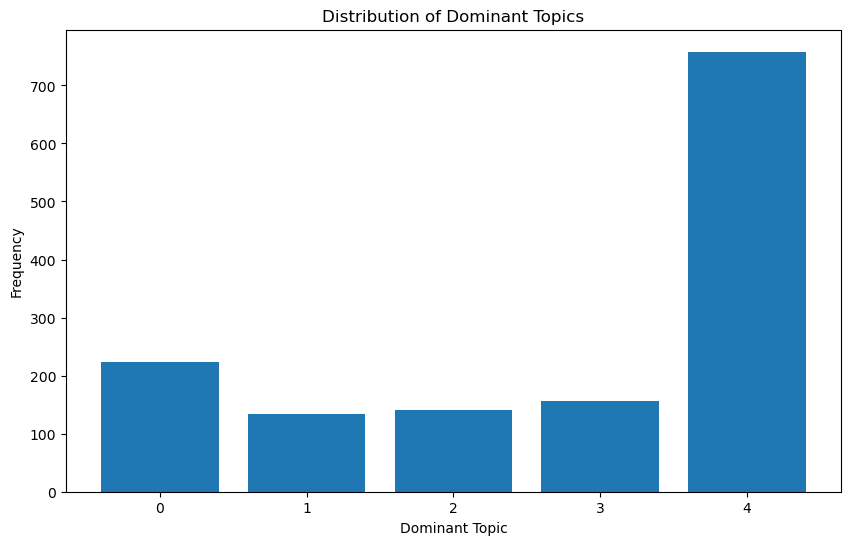

In [15]:
import matplotlib.pyplot as plt

# Count the frequency of each dominant topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts()

# Sort the topics by their frequencies
sorted_topics = topic_counts.sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_topics.index, sorted_topics.values)
plt.xlabel('Dominant Topic')
plt.ylabel('Frequency')
plt.title('Distribution of Dominant Topics')
plt.xticks(sorted_topics.index)
plt.show()